In [9]:
from pyspark.sql import SparkSession
import datetime as dt
import matplotlib.pyplot as plt
import mysql.connector as dbconnect
from rich import print
from pyspark.sql.functions import concat, lit, substring, lpad, col, initcap, lower, trim, concat_ws, regexp_replace, when, length, sum
import seaborn as sb
from mysql.connector import Error
from datetime import datetime
import requests
import json
import calendar

spark = SparkSession.builder\
        .appName("CDW Sapp")\
        .config("spark.jars", r"C:\Spark\jars\mysql-connector-java-8.0.23.jar")\
        .getOrCreate()

def extract():  # Creating an extract function to read the JSON files as dataframes.

    branch_df = spark.read.option("multiline", "true").json("cdw_sapp_branch.json")
    credit_df = spark.read.option("multiline", "true").json("cdw_sapp_credit.json")
    customer_df = spark.read.option("multiline", "true").json("cdw_sapp_customer.json")

    # Fetch loan data from API
    loan_url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
    response = requests.get(loan_url)

    # Check status code
    print(f"Loan Data API Status Code: {response.status_code}")
    if response.status_code == 200:
        # Save JSON to a file so Spark can read it
        with open("loan_data.json", "w") as f: #Saves the fetched JSON data to a local file (loan_data.json), because Spark can only load from files or structured sources, not directly from memory or an HTTP response.
            json.dump(response.json(), f)

        # Load loan data into DataFrame
        loan_df = spark.read.option("multiline", "true").json("loan_data.json")
    else:
        print("Failed to fetch loan data.")
        loan_df = spark.createDataFrame([], schema=None)  # Empty fallback

    return customer_df, branch_df, credit_df, loan_df

customer_df, branch_df, credit_df, loan_df = extract()


customer_df.show(truncate=False, vertical=True)
branch_df.show(truncate=False, vertical=True)
credit_df.show(truncate=False, vertical=True)

Loan Data API Status Code: 200

-RECORD 0---------------------------------------
 APT_NO         | 656                           
 CREDIT_CARD_NO | 4210653310061055              
 CUST_CITY      | Natchez                       
 CUST_COUNTRY   | United States                 
 CUST_EMAIL     | AHooper@example.com           
 CUST_PHONE     | 1237818                       
 CUST_STATE     | MS                            
 CUST_ZIP       | 39120                         
 FIRST_NAME     | Alec                          
 LAST_NAME      | Hooper                        
 LAST_UPDATED   | 2018-04-21T12:49:02.000-04:00 
 MIDDLE_NAME    | Wm                            
 SSN            | 123456100                     
 STREET_NAME    | Main Street North             
-RECORD 1---------------------------------------
 APT_NO         | 829                           
 CREDIT_CARD_NO | 4210653310102868              
 CUST_CITY      | Wethersfield                  
 CUST_COUNTRY   | United States                 
 CUST_EMAIL     | EH

In [2]:
def transform(customer_df, branch_df, credit_df):
    #Using .withcolumn to format customer names in customer_df to their desired structer using initcap, trim to remove spaces on the end, and col to specifiy the column.
    #Convert the Name to Title Case
    customer_df = customer_df.withColumn("FIRST_NAME", initcap(trim(col("FIRST_NAME")))) #initcap is the pyspark version of .title
    
    #Convert the middle name in lower case
    customer_df = customer_df.withColumn("MIDDLE_NAME", lower(trim(col("MIDDLE_NAME"))))
    
    #Convert the Last Name in Title Case
    customer_df = customer_df.withColumn("LAST_NAME", initcap(trim(col("LAST_NAME"))))
    
    #Concatenate Apartment no and Street name of customer's Residence with comma as a seperator (Street, Apartment) 
    customer_df = customer_df.withColumn("FULL_STREET_ADDRESS",concat(trim(col("STREET_NAME")), 
                            lit(", Apt# "), trim(col("APT_NO")))).drop("APT_NO", "STREET_NAME") #dropping the APT_NO and STREET_NAME
    
    #Change the format of phone number to (XXX)XXX-XXXX
    customer_df = customer_df.withColumn(
            "CUST_PHONE_CLEAN",
            regexp_replace(col("CUST_PHONE"), r"\D", "")# Removing all non-digit characters from the phone number
        ).withColumn(
            "CUST_PHONE_FORMATTED",
            when(
                length(col("CUST_PHONE_CLEAN")) == 10, #If number has 10 digits, format as (XXX)XXX-XXXX
                concat(lit("("), substring(col("CUST_PHONE_CLEAN"), 1, 3), lit(")"),
                substring(col("CUST_PHONE_CLEAN"), 4, 3), lit("-"),
                substring(col("CUST_PHONE_CLEAN"), 7, 4))
            ).when(
                length(col("CUST_PHONE_CLEAN")) == 7, #If number has 7 digits, format as XXX-XXX-XXXX with 'XXX-' placeholder area code
                concat(lit("(XXX)"),
                substring(col("CUST_PHONE_CLEAN"), 1, 3), lit("-"),
                substring(col("CUST_PHONE_CLEAN"), 4, 4))
            ).otherwise(lit("INVALID")) #For anything not 7 or 10 digits, label as INVALID
        )
    
        #Dropping the original "CUST_PHONE" column and the column "CUST_PHONE_CLEAN" that was created for the transform process
    customer_df = customer_df.drop("CUST_PHONE", "CUST_PHONE_CLEAN") \
                         .withColumnRenamed("CUST_PHONE_FORMATTED", "CUST_PHONE") #Renaming final product "CUST_PHONE_FORMATTED" to the original column name "CUST_PHONE"
    
    #If the source value is null load default (99999) value else Direct move
    branch_df = branch_df.fillna({'branch_zip': '99999'})
    
    #Change the format of phone number to (XXX)XXX-XXXX
    branch_df = branch_df \
        .withColumn("BRANCH_PHONE_CLEAN", regexp_replace(col("BRANCH_PHONE"), r"\D", "")) \
        .withColumn("BRANCH_PHONE_FORMATTED",
            when(
                length(col("BRANCH_PHONE_CLEAN")) == 10,
                concat(
                    lit("("), substring(col("BRANCH_PHONE_CLEAN"), 1, 3), lit(")"),
                    substring(col("BRANCH_PHONE_CLEAN"), 4, 3), lit("-"),
                    substring(col("BRANCH_PHONE_CLEAN"), 7, 4)
                )
            )
        )
        # Dropping the original "BRANCH_PHONE" column and the column "BRANCH_PHONE_CLEAN" that was created for the transform process
    branch_df = branch_df.drop("BRANCH_PHONE", "BRANCH_PHONE_CLEAN") \
                .withColumnRenamed("BRANCH_PHONE_FORMATTED", "BRANCH_PHONE") #Renaming final product "BRANCH_PHONE_FORMATTED" to the original column name "BRANCH_PHONE"
    
    # Renaming CREDIT_CARD_NO column to CUST_CC_NO per mapping document
    credit_df = credit_df.withColumnRenamed("CREDIT_CARD_NO", "CUST_CC_NO")

    #Convert DAY, MONTH, and YEAR into a TIMEID (YYYYMMDD)
    credit_df = credit_df.withColumn("TIMEID", #Creates Column "DATE"
                concat(col("YEAR").cast("string"), # Concatinating "YEAR" "MONTH" and "DAY"
                lpad(col("MONTH").cast("string"), 2, "0"), #Left padding the "MONTH" column with "0" until it is 2 elements long. 
                lpad(col("DAY").cast("string"), 2, "0") #Same process as month but for the "DAY" column
            )
        ).drop("MONTH", "DAY", "YEAR")
    return customer_df, branch_df, credit_df

customer_df, branch_df, credit_df = transform(customer_df, branch_df, credit_df)


customer_df.show(truncate=False, vertical=True)
branch_df.show(truncate=False, vertical=True)
credit_df.show(truncate=False, vertical=True)

-RECORD 0--------------------------------------------
 CREDIT_CARD_NO      | 4210653310061055              
 CUST_CITY           | Natchez                       
 CUST_COUNTRY        | United States                 
 CUST_EMAIL          | AHooper@example.com           
 CUST_STATE          | MS                            
 CUST_ZIP            | 39120                         
 FIRST_NAME          | Alec                          
 LAST_NAME           | Hooper                        
 LAST_UPDATED        | 2018-04-21T12:49:02.000-04:00 
 MIDDLE_NAME         | wm                            
 SSN                 | 123456100                     
 FULL_STREET_ADDRESS | Main Street North, Apt# 656   
 CUST_PHONE          | (XXX)123-7818                 
-RECORD 1--------------------------------------------
 CREDIT_CARD_NO      | 4210653310102868              
 CUST_CITY           | Wethersfield                  
 CUST_COUNTRY        | United States                 
 CUST_EMAIL          | EHolm

In [3]:
# credit_db_df = spark.read.format("jdbc").options(      #Extracting data from sql(use different variable name to not overwrite the dataframes)
#      driver="com.mysql.cj.jdbc.Driver",
#      user="root",                                                  #Use for seaborn
#      password="password",
#      url="jdbc:mysql://localhost:3306/creditcard_capstone_db",
#      dbtable="credit_data").load()
import mysql.connector
from mysql.connector import Error

conn = None

try:
    conn = mysql.connector.connect(
        host='127.0.0.1',
        user='root',
        password='password'
    )

    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("create database if not exists creditcard_capstone_db")
        print("Database created.")

except Error as e:
    print(f"Error: {e}")

finally:
    if conn and conn.is_connected():
        cursor.close()
        conn.close()
        print("MySQL closed.")

#creating tables in SQL
def load(df, table_name):
    df.write\
    .format("jdbc")\
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone_db")\
    .option("driver", "com.mysql.cj.jdbc.Driver")\
    .option("dbtable", table_name)\
    .option("user", "root")\
    .option("password", "password")\
    .mode("overwrite")\
    .save()

load(customer_df, "customer_data")
load(branch_df, "branch_data")
load(credit_df, "credit_data")
load(loan_df, "cdw_sapp_loan_application")

Database created.

MySQL closed.

In [ ]:
import mysql.connector
from mysql.connector import Error
from datetime import datetime

def get_zip_code():
    while True:
        zip_code = input("Enter a 5-digit ZIP code: ").strip()
        if zip_code.isdigit() and len(zip_code) == 5:
            return zip_code
        print("Invalid ZIP code. Must be 5 digits.")

def get_month():
    while True:
        month = input("Enter the month (1-12): ").strip()
        if month.isdigit() and 1 <= int(month) <= 12:
            return int(month)
        print("Invalid month. Must be between 1 and 12.")

def get_year():
    current_year = datetime.now().year
    while True:
        year = input("Enter the 4-digit year (e.g., 2025): ").strip()
        if year.isdigit() and 1900 <= int(year) <= current_year:
            return int(year)
        print(f"Invalid year. Must be between 1900 and {current_year}.")

def fetch_transactions(zip_code, month, year):
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='password',
            database='creditcard_capstone_db'
        )

        if conn.is_connected():
            cursor = conn.cursor(dictionary=True)
            query = """
                SELECT cu.FIRST_NAME, cu.LAST_NAME, cr.TRANSACTION_ID, cr.TRANSACTION_TYPE,
                       cr.TRANSACTION_VALUE, 
                       MONTH(cr.TIMEID) AS TRANSACTION_MONTH, 
                       YEAR(cr.TIMEID) AS TRANSACTION_YEAR, 
                       DAY(cr.TIMEID) AS TRANSACTION_DAY
                FROM credit_data cr
                JOIN customer_data cu ON cr.CUST_SSN = cu.SSN
                WHERE cu.CUST_ZIP = %s 
                  AND MONTH(cr.TIMEID) = %s 
                  AND YEAR(cr.TIMEID) = %s
                ORDER BY TRANSACTION_DAY DESC;
            """
            cursor.execute(query, (zip_code, month, year))
            results = cursor.fetchall()

            if results:
                for row in results:
                    print(f"{row['FIRST_NAME']} {row['LAST_NAME']} | "
                          f"Type: {row['TRANSACTION_TYPE']} | "
                          f"Amount: ${row['TRANSACTION_VALUE']} | "
                          f"Date: {row['TRANSACTION_MONTH']:02d}/"
                          f"{row['TRANSACTION_DAY']:02d}/"
                          f"{row['TRANSACTION_YEAR']}")
            else:
                print("No transactions found.")

    except Error as e:
        print(f"Database error: {e}")
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def generate_monthly_statement(cc_no, month, year):
    last_day = calendar.monthrange(year, month)[1]
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='password',
            database='creditcard_capstone_db'
        )

        if conn.is_connected():
            cursor = conn.cursor(dictionary=True)
            
            first_day_of_month = int(f"{year:04d}{month:02d}01")
            prev_balance_query = """
                SELECT 
                    COALESCE(SUM(TRANSACTION_VALUE), 0) AS PREVIOUS_BALANCE
                FROM 
                    credit_data
                WHERE 
                    CUST_CC_NO = %s
                    AND TIMEID < %s;
            """
            cursor.execute(prev_balance_query, (cc_no, first_day_of_month))
            prev_balance = cursor.fetchone()['PREVIOUS_BALANCE']
            
            current_month_query = """
                SELECT 
                    cd.TIMEID,
                    cd.TRANSACTION_TYPE,
                    cd.TRANSACTION_VALUE,
                    cd.BRANCH_CODE,
                    cust.FIRST_NAME,
                    cust.LAST_NAME
                FROM 
                    credit_data cd
                JOIN 
                    customer_data cust ON cd.CUST_CC_NO = cust.CREDIT_CARD_NO
                WHERE 
                    cd.CUST_CC_NO = %s
                    AND MONTH(cd.TIMEID) = %s
                    AND YEAR(cd.TIMEID) = %s
                ORDER BY 
                    cd.TIMEID;
            """
            cursor.execute(current_month_query, (cc_no, month, year))
            transactions = cursor.fetchall()

            if not transactions:
                print("No transactions found for this card and period.")
                return

            customer_name = f"{transactions[0]['FIRST_NAME']} {transactions[0]['LAST_NAME']}"

            current_month_total = sum(tx['TRANSACTION_VALUE'] for tx in transactions)

            # New balance = previous balance + current month total
            new_balance = prev_balance + current_month_total

            # Minimum payment based on new balance
            min_payment = max(round(new_balance * 0.05, 2), 25) if new_balance > 0 else 0

            last_day = calendar.monthrange(year, month)[1]

            # Print statement
            print("\n" + "="*50)
            print(f"CREDIT CARD STATEMENT - {month}/{year}")
            print("="*50)
            print(f"Customer Name  : {customer_name}")
            print(f"Credit Card No : {cc_no}")
            print(f"Billing Period : {month}/01/{year} to {month}/{last_day}/{year}")
            print(f"Previous Balance: ${prev_balance:.2f}")
            print(f"Current Charges: ${current_month_total:.2f}")
            print(f"New Balance   : ${new_balance:.2f}")
            print(f"Min Payment Due: ${min_payment:.2f}")
            if month != 12:
                print(f"Due Date       : {month+1}/{last_day}/{year}")
            else:
                print(f"Due Date       : 01/{last_day}/{year+1}")
            print("-" * 50)
            print("DATE        | TYPE       | AMOUNT    | BRANCH")
            print("-" * 50)
            for tx in transactions:
                date = datetime.strptime(tx['TIMEID'], '%Y%m%d').strftime('%Y-%m-%d')
                print(f"{date} | {tx['TRANSACTION_TYPE']:10} | ${tx['TRANSACTION_VALUE']:8.2f} | {tx['BRANCH_CODE']}")
            print("="*50)

    except mysql.connector.Error as e:
        print(f"Database error: {e}")

    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def query_account_details(ssn):
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='password',
            database='creditcard_capstone_db'
        )
        if conn.is_connected():
            cursor = conn.cursor(dictionary=True)
            query = "SELECT * FROM customer_data WHERE SSN = %s"
            cursor.execute(query, (ssn,))
            result = cursor.fetchone()
            if result:
                print("Customer Account Details:")
                for key, value in result.items():
                    print(f"{key}: {value}")
            else:
                print("No customer found with that SSN.")

    except mysql.connector.Error as e:
        print(f"Database error: {e}")
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def modify_account_details(ssn, field, new_value):
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='password',
            database='creditcard_capstone_db'
        )
        if conn.is_connected():
            cursor = conn.cursor()
            query = f"UPDATE customer_data SET {field} = %s WHERE SSN = %s"
            cursor.execute(query, (new_value, ssn))
            conn.commit()
            print("Account updated successfully.")

    except mysql.connector.Error as e:
        print(f"Database error: {e}")
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()

def query_transactions_between_dates(start_date, end_date):
    try:
        conn = mysql.connector.connect(
            host='localhost',
            user='root',
            password='password',
            database='creditcard_capstone_db'
        )
        if conn.is_connected():
            cursor = conn.cursor(dictionary=True)
            query = """
                SELECT * FROM credit_data
                WHERE TIMEID BETWEEN %s AND %s
                ORDER BY YEAR(TIMEID) DESC, MONTH(TIMEID) DESC, DAY(TIMEID) DESC;
            """
            cursor.execute(query, (start_date, end_date))
            results = cursor.fetchall()
            for row in results:
                print(f"{row['CUST_CC_NO']} | Type: {row['TRANSACTION_TYPE']} | "
                      f"Amount: ${row['TRANSACTION_VALUE']} | Date: {row['TIMEID']}")
    except mysql.connector.Error as e:
        print(f"Database error: {e}")
    finally:
        if conn.is_connected():
            cursor.close()
            conn.close()



In [5]:
loan_db_df = spark.read.format("jdbc").options(      #Extracting data from sql(use different variable name to not overwrite the dataframes)
      driver="com.mysql.cj.jdbc.Driver",
      user="root",                                                  #Use for seaborn
      password="password",
      url="jdbc:mysql://localhost:3306/creditcard_capstone_db",
      dbtable="cdw_sapp_loan_application").load()

+----------------+-----------------+
|TRANSACTION_TYPE|TRANSACTION_COUNT|
+----------------+-----------------+
|       Education|             6638|
|   Entertainment|             6635|
|      Healthcare|             6723|
|         Grocery|             6549|
|            Test|             6683|
|             Gas|             6605|
|           Bills|             6861|
+----------------+-----------------+



C:\Users\alexander.arena\AppData\Local\Temp\ipykernel_31964\1422933130.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=transaction_type_count_pd, x="TRANSACTION_TYPE", y="TRANSACTION_COUNT", palette="Blues_d")


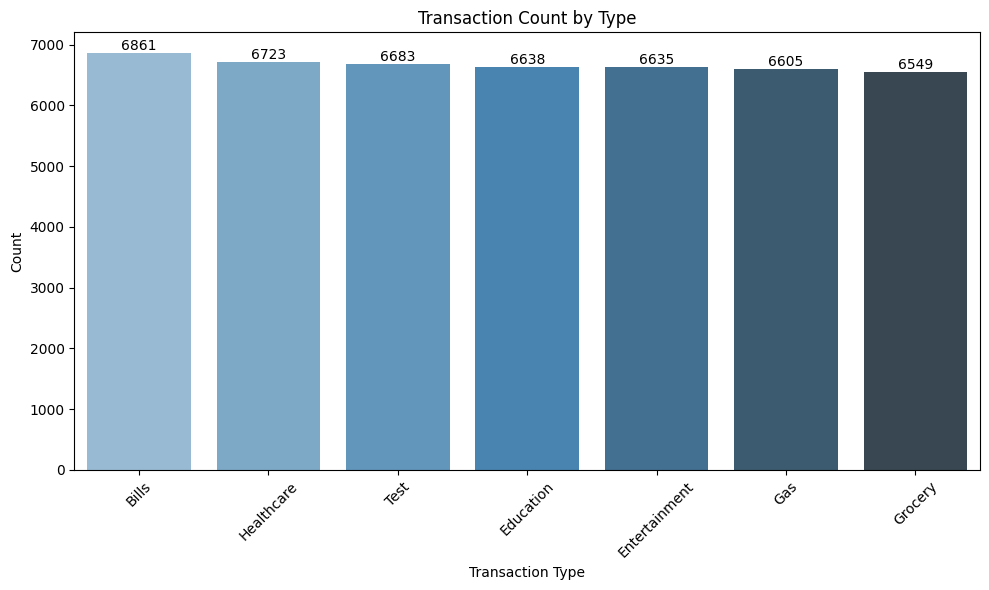

In [6]:
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import seaborn as sns

# Group by TRANSACTION_TYPE and count occurrences
transaction_type_count_df = credit_df.groupBy("TRANSACTION_TYPE").agg(count("*").alias("TRANSACTION_COUNT"))

# Convert to Pandas for Seaborn visualization
transaction_type_count_pd = transaction_type_count_df.toPandas()

# Sort for cleaner plot
transaction_type_count_pd.sort_values(by="TRANSACTION_COUNT", ascending=False, inplace=True)

transaction_type_count_df.show()

# Plot using Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=transaction_type_count_pd, x="TRANSACTION_TYPE", y="TRANSACTION_COUNT", palette="Blues_d")

# Annotate each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Transaction Count by Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\alexander.arena\AppData\Local\Temp\ipykernel_31964\3294086558.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_states, x="CUST_STATE", y="CUSTOMER_COUNT", palette="dark")


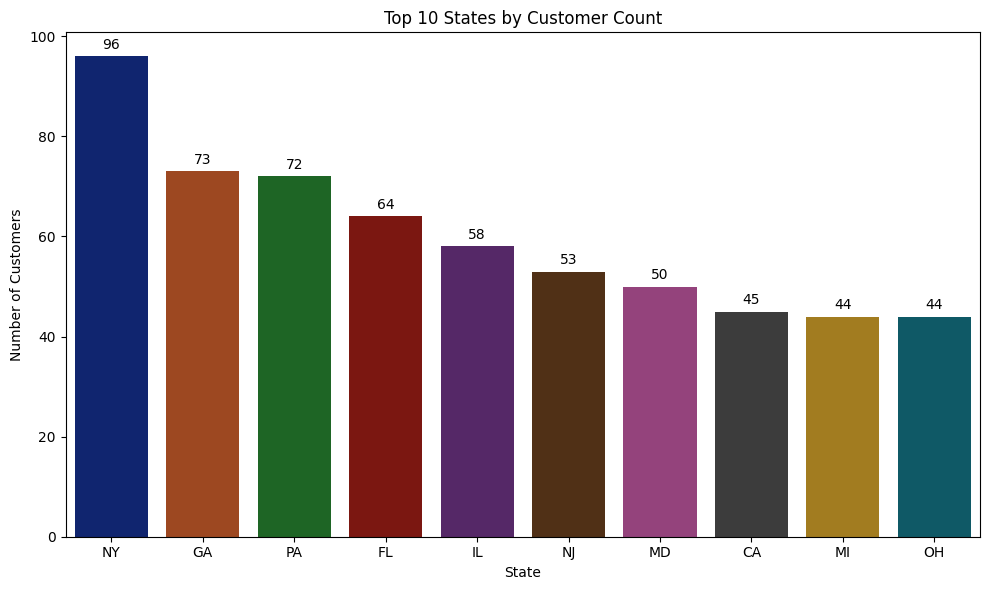

In [7]:
# Group by state and count customers
state_count_df = customer_df.groupBy("CUST_STATE").agg(count("*").alias("CUSTOMER_COUNT"))

# Convert to Pandas for plotting
state_count_pd = state_count_df.toPandas()

# Sort and take top 10
top_states = state_count_pd.sort_values(by="CUSTOMER_COUNT", ascending=False).head(10)

# Plot with labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=top_states, x="CUST_STATE", y="CUSTOMER_COUNT", palette="dark")

# Annotate each bar with the customer count
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Top 10 States by Customer Count")
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.tight_layout()
plt.show()

C:\Users\alexander.arena\AppData\Local\Temp\ipykernel_31964\2132915295.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TOTAL_SPENT', y='CUSTOMER_NAME', data=top_customers_pd, palette='magma')


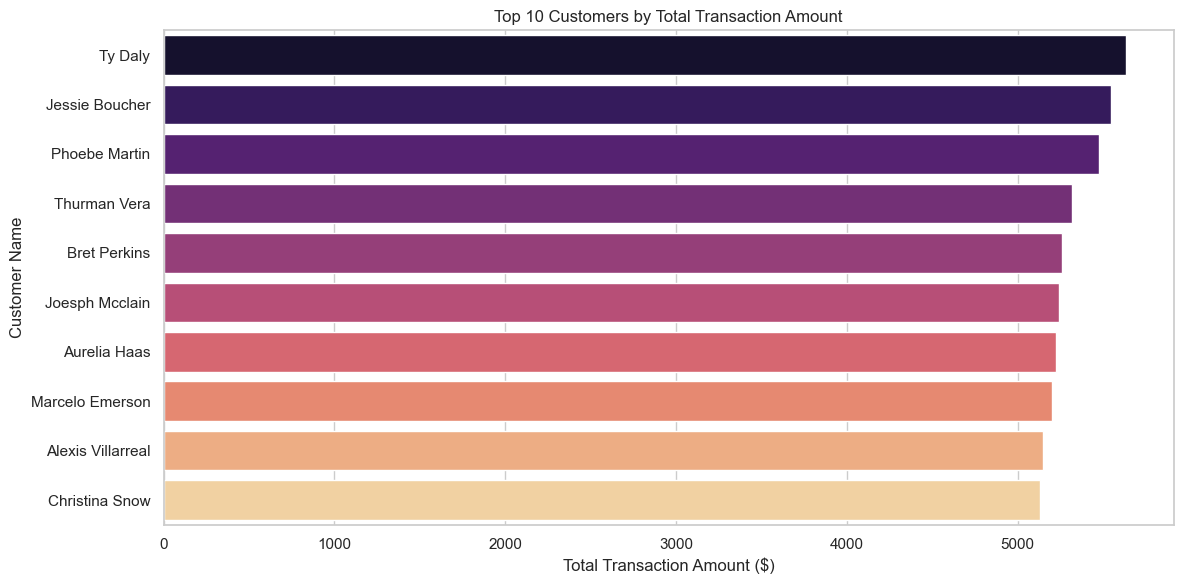

In [10]:
joined_df = credit_df.join(customer_df, credit_df["CUST_SSN"] == customer_df["SSN"])

agg_df = joined_df.withColumn("CUSTOMER_NAME", concat_ws(" ", "FIRST_NAME", "LAST_NAME")) \
    .groupBy("CUSTOMER_NAME") \
    .agg(sum("TRANSACTION_VALUE").alias("TOTAL_SPENT")) \
    .orderBy("TOTAL_SPENT", ascending=False) \
    .limit(10)

# Convert to Pandas for plotting
top_customers_pd = agg_df.toPandas()

# Plotting with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='TOTAL_SPENT', y='CUSTOMER_NAME', data=top_customers_pd, palette='magma')
plt.title('Top 10 Customers by Total Transaction Amount')
plt.xlabel('Total Transaction Amount ($)')
plt.ylabel('Customer Name')
plt.tight_layout()
plt.show()

C:\Users\alexander.arena\AppData\Local\Temp\ipykernel_31964\480546220.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Status", y="Count", data=plot_df, palette="Blues_d")


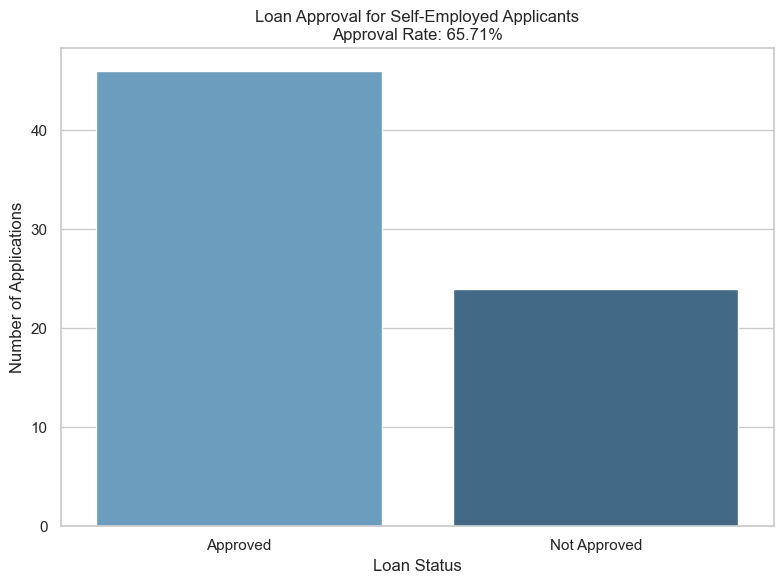

In [13]:
spark = SparkSession.builder.appName("Loan Approval Analysis").getOrCreate()

self_employed_df = loan_df.filter(col("Self_Employed") == "Yes")

# Filter for self-employed applicants and calculate counts
approval_stats = self_employed_df.groupBy().agg(
    count(when(col("application_status") == "Y", True)).alias("Approved"),
    count("*").alias("Total")
)

# Calculate percentage
stats_pd = approval_stats.toPandas()
approved = stats_pd["Approved"][0]
total = stats_pd["Total"][0]
percentage = (approved / total) * 100 if total else 0

# Prepare data for plotting
plot_data = {
    "Status": ["Approved", "Not Approved"],
    "Count": [approved, total - approved]
}

# Convert to DataFrame for Seaborn
import pandas as pd
plot_df = pd.DataFrame(plot_data)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x="Status", y="Count", data=plot_df, palette="Blues_d")
plt.title(f"Loan Approval for Self-Employed Applicants\nApproval Rate: {percentage:.2f}%")
plt.ylabel("Number of Applications")
plt.xlabel("Loan Status")
plt.tight_layout()
plt.show()

In [11]:
def main_menu():
    while True:
        print("\n[ Main Menu ]")
        print("0. Exit")
        print("1. View transactions by ZIP/month/year")
        print("2. Generate monthly bill")
        print("3. Search account details")
        print("4. Modify account details")
        print("5. Lookup transactions between two dates")
        
        choice = input("Choose an option (0-5): ").strip()

        if choice == '1':
            zip_code = get_zip_code()
            month = get_month()
            year = get_year()
            fetch_transactions(zip_code, month, year)

        elif choice == '2':
            cc_no = input("Enter Credit Card Number: ").strip()
            month = get_month()
            year = get_year()
            generate_monthly_statement(cc_no, month, year)

        elif choice == '3':
            ssn = input("Enter Customer SSN: ").strip()
            query_account_details(ssn)

        elif choice == '4':
            ssn = input("Enter Customer SSN: ").strip()
            field = input("Enter field name to update (e.g., EMAIL, CUST_PHONE): ").strip()
            new_value = input("Enter new value: ").strip()
            modify_account_details(ssn, field, new_value)

        elif choice == '5':
            start_date = input("Enter start date (YYYYMMDD): ").strip()
            end_date = input("Enter end date (YYYYMMDD): ").strip()
            query_transactions_between_dates(start_date, end_date)

        elif choice == '0':
            print("Goodbye.")
            break
        else:
            print("Invalid option. Try again.")

if __name__ == "__main__":
    main_menu()

[ Main Menu ]

0. Exit

1. View transactions by ZIP/month/year

2. Generate monthly bill

3. Search account details

4. Modify account details

5. Lookup transactions between two dates

==================================================

CREDIT CARD STATEMENT - 12/2018

==================================================

Customer Name  : Alec Hooper

Credit Card No : 4210653310061055

Billing Period : 12/01/2018 to 12/31/2018

Previous Balance: $1884.56

Current Charges: $140.30

New Balance   : $2024.86

Min Payment Due: $101.24

Due Date       : 01/31/2019

--------------------------------------------------

DATE        | TYPE       | AMOUNT    | BRANCH

--------------------------------------------------

2018-12-05 | Entertainment | $   46.60 | 59

2018-12-10 | Entertainment | $   84.13 | 8

2018-12-28 | Bills      | $    9.57 | 74

==================================================

[ Main Menu ]

0. Exit

1. View transactions by ZIP/month/year

2. Generate monthly bill

3. Search account details

4. Modify account details

5. Lookup transactions between two dates

Goodbye.